# Iris area extraction

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from faceparsing.parser import FaceParser
from imagine.shape.segment import ParsingSegmenter
from imagine.color import conversion
from imagine.shape import operations
from automakeup.feature.face import ClusteringIrisShapeExtractor, HoughCircleIrisShapeExtractor
from automakeup.face import extract as face_extraction, bounding
from mtcnn import MTCNN

In [2]:
parser = FaceParser()

In [3]:
mtcnn = MTCNN()

In [4]:
face_extractor = face_extraction.SimpleFaceExtractor(512, interpolation=cv2.INTER_CUBIC)
bb_finder = bounding.MTCNNBoundingBoxFinder(mtcnn)

In [5]:
def crop_to_eye(img, parser):
    eyes_mask = ParsingSegmenter(parser, parts_map={"l_eye": 1, "r_eye": 1})(img) == 1
    biggest_eye_contour = operations.biggest_contour(eyes_mask)
    eye_rect = operations.bounding_rect(biggest_eye_contour)
    eye_rect_square = operations.safe_rect(operations.squarisize(eye_rect), img.shape, allow_scaling=True)
    crop = operations.Crop(eye_rect_square)
    img_cropped = crop(img)
    eye_mask_cropped = crop(np.array(eyes_mask, dtype=np.uint8))
    eye_mask_cropped = operations.Erode(round(0.1 * eye_rect.height()))(eye_mask_cropped)
    return img_cropped, eye_mask_cropped != 0

In [6]:
def show_iris(eye, mask, extractor):
    iris_mask = extractor.extract(eye, mask)
    fig, axs = plt.subplots(1, 4, figsize=(10, 4))
    axs[0].imshow(eye)
    axs[0].title.set_text("Image cropped to eye")
    axs[0].set_axis_off()
    axs[1].imshow(np.where(mask[...,None], eye, 0))
    axs[1].title.set_text("Search area")
    axs[1].set_axis_off()
    axs[2].imshow(iris_mask, cmap="gray")
    axs[2].title.set_text("Iris mask")
    axs[2].set_axis_off()
    axs[3].imshow(np.where(iris_mask[...,None], eye, 0))
    axs[3].title.set_text("Mask applied to image")
    axs[3].set_axis_off()
    plt.tight_layout()
    plt.show()

### Comparison of extraction methods

In [7]:
image_paths = ["faces/" + f for f in os.listdir("faces")]

##### Clustering

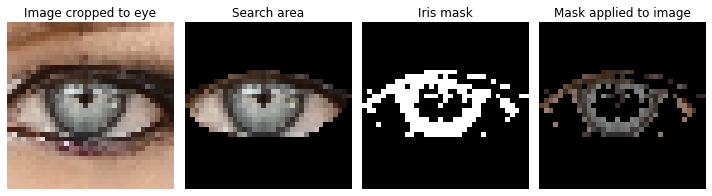

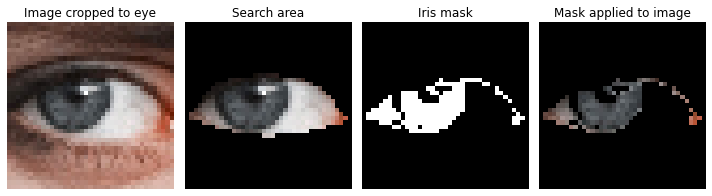

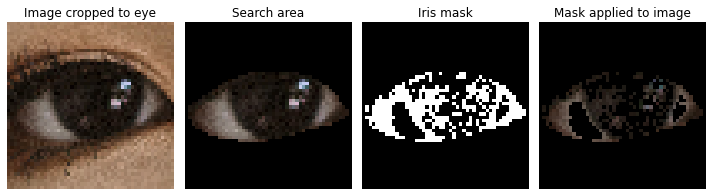

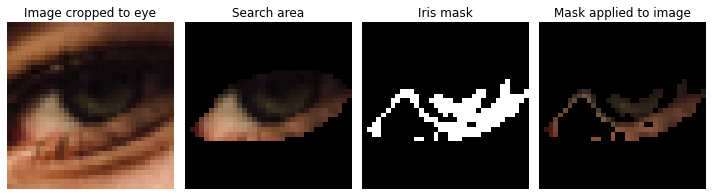

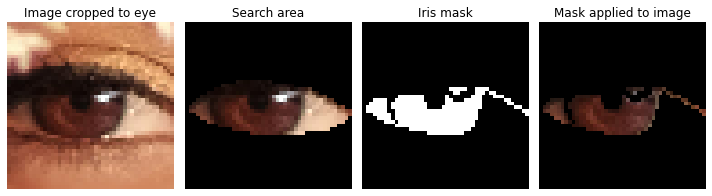

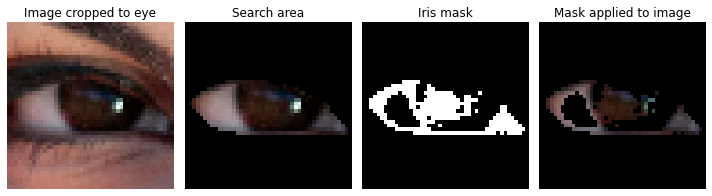

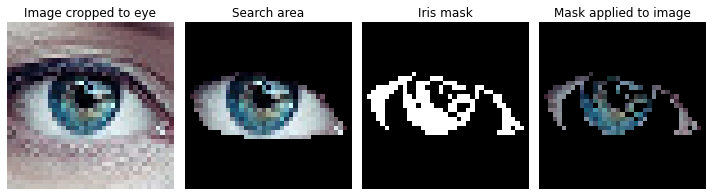

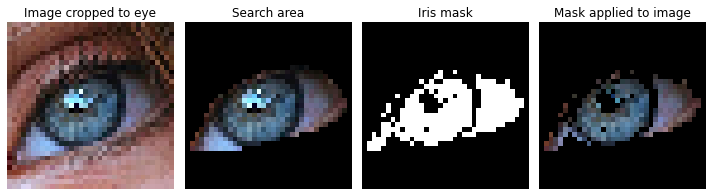

In [8]:
extractor = ClusteringIrisShapeExtractor()
for path in image_paths:
    image = conversion.BgrToRgb(cv2.imread(path))
    bb = bb_finder.find(image)
    image = face_extractor.extract(image, bb)
    eye, mask = crop_to_eye(image, parser)
    show_iris(eye, mask, extractor)

##### Hough circles

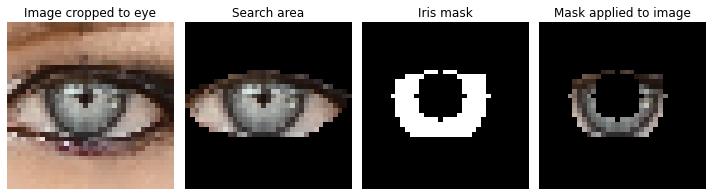

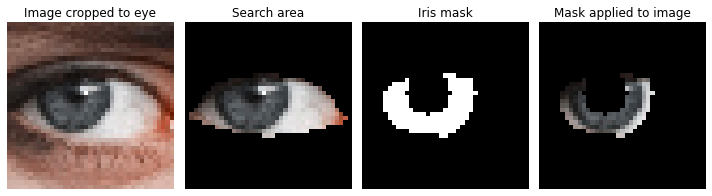

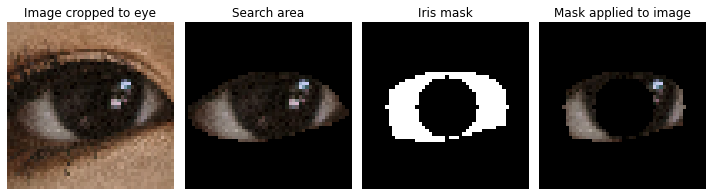

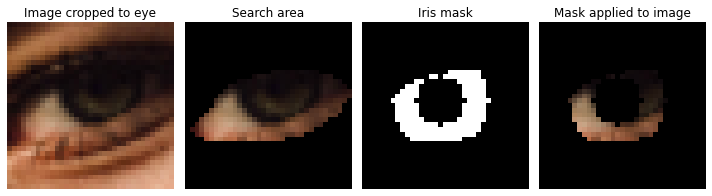

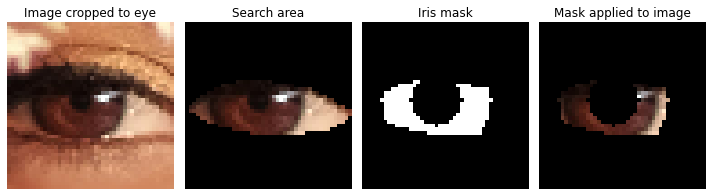

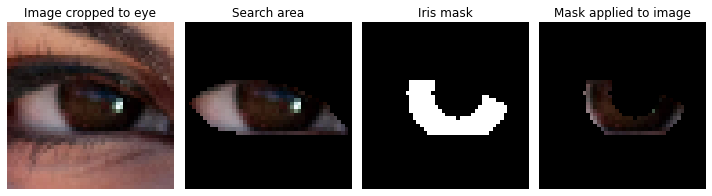

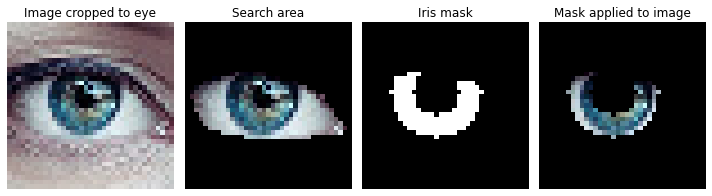

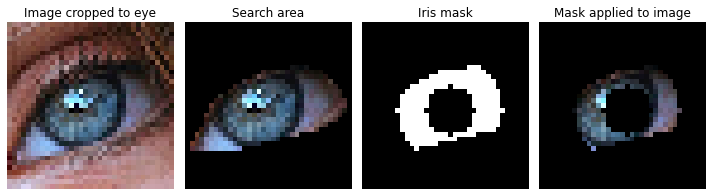

In [9]:
extractor = HoughCircleIrisShapeExtractor()
for path in image_paths:
    image = conversion.BgrToRgb(cv2.imread(path))
    bb = bb_finder.find(image)
    image = face_extractor.extract(image, bb)
    eye, mask = crop_to_eye(image, parser)
    show_iris(eye, mask, extractor)